<a href="https://colab.research.google.com/github/mhuertascompany/EDE21/blob/main/cycle2/Sersic_Reff_tfp_EDE21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GALAXY SIZES WITH CNNs AND TENSORFLOW PROBABILITY

The purpose of this tutorial is to estimate galaxy half light radii of galaxies from images. Galaxy sizes are traditionnally estimated by fitting a [PSF-convolved Sersic model](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html) to galaxy images. We are going to use a CNN instead. The network takes then as input a galaxy image convolved with a PSF and outputs its effective radius. The same approach can be used to estiamte other parameters such as ellipticiites. See [Tuccillo+18](http://adsabs.harvard.edu/abs/2018MNRAS.475..894T) for an illustration. In this tutorial we are going a step further by estimating the posterior distribution of sizes instead of a single point estimate. The posterior is modeled with a gaussian mixture model using TF probability.

![](https://drive.google.com/uc?id=1R9ITrzxUG0X9VjwFUhbbwsDhZD8A4ANy)

---



#### Before we start, make sure to open this Colab notebook in "PlayGround Mode" (top left) and to change the Runtime type to GPU by navigating to the toolbar and clicking Runtime -> Change runtime type and then changing Hardware accelerator to GPU

---





## Import packages


In [ ]:
import os
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pdb
import pickle
from astropy.io import fits
from astropy.visualization.stretch import SqrtStretch
from astropy.visualization import ImageNormalize, MinMaxInterval

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data download and preparation

Before mounting the drive click on [this folder](https://drive.google.com/drive/folders/1PcftgBzBySo1Ync-Wdsp9arTCJ_MfEPE?usp=sharing) and add it to your google drive by following these steps:

*   Go to your drive 
*   Find shared folder ("Shared with me" link)
*   Right click it
*   Click Add to My Drive



Mount your drive into Colab:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then load the data for training. The dataset (X) contains 2 numpy arrays with the galaxy images (128*128 pixels) and the known effective radii for every galaxy. For the training we are using Single Sersic Models convolved with an HST PSF and with real HST noise added. The effective size of the modeled galaxies is thus known and stored in vector Y. The goal is to estimate Y from X.

In [ ]:
#Load data
pathinData="/content/drive/My Drive/EDE21/sizes"

#images
X = np.load(pathinData+'/Stamps_Simulated_Galaxies_tutorial.npy')

#sizes
Y = np.load(pathinData+'/Parameters_Simulated_Galaxies_tutorial.npy') 


In [ ]:
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
# rescaling the sizes with mean and variance
for i in range(len(X)):
  X[i,:,:]=X[i,:,:]/np.max(X[i,:,:])
scalerY =  MinMaxScaler().fit(Y.reshape((-1,1)))
Ys = scalerY.transform(Y.reshape((-1,1)))
Y_o=Y
#scaler = StandardScaler().fit(X)
#Xs = scaler.transform(Xs)


# Spliting in Training, Test and validations datasets
x_train = X[0:len(X)//5*3,0,:,:] 
x_val = X[len(X)//5*3:len(X)//5*4,0,:,:]  
x_test = X[len(X)//5*4:,0,:,:]
t_train = Ys[0:len(Ys)//5*3,:]
t_val = Ys[len(Ys)//5*3:len(Ys)//5*4,:]
t_test = Ys[len(Ys)//5*4:,:]
        
print(np.max(t_train),np.min(t_train))

x_train=np.expand_dims(x_train,axis=3)
x_test=np.expand_dims(x_test,axis=3)
x_val=np.expand_dims(x_val,axis=3)
print ('Y_train.shape= ', t_train.shape)  
print ('X_train.shape= ', x_train.shape) 
print ('X_val.shape= ', x_val.shape) 
print ('Y_val.shape= ', t_val.shape) 
print ('Y_test.shape= ', t_test.shape)  
print ('X_test.shape= ', x_test.shape) 


1.0 0.0023418971036074446
Y_train.shape=  (18000, 1)
X_train.shape=  (18000, 128, 128, 1)
X_val.shape=  (6000, 128, 128)
Y_val.shape=  (6000, 1)
Y_test.shape=  (6000, 1)
X_test.shape=  (6000, 128, 128, 1)


## Visualize images

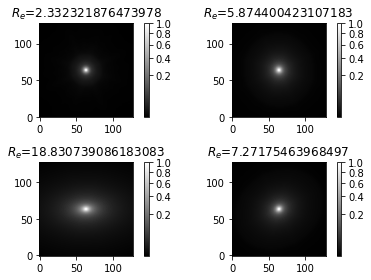

In [ ]:
stretch = SqrtStretch() 

randomized_inds_train = np.random.permutation(len(x_train))


fig = plt.figure()
for i,j in zip(randomized_inds_train[0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  interval = MinMaxInterval()
  vmin, vmax = interval.get_limits(x_train[i,:,:])
  norm = ImageNormalize(stretch=stretch)
  im = ax.imshow(x_train[i,:,:,0], origin='lower', cmap='gray',
    vmin=vmin, norm=norm,vmax=vmax)
  plt.title('$R_e$='+str(Y_o[i]))
  fig.tight_layout() 
  fig.colorbar(im)


## Model Setup

The follwing cells define the neural network architecture. We use here the Tensorflow Esitmator API. The function _mdn_model_fn defines the model. It is made of 6 convolutional layers with some pooling operations. The output of the convolutional part is then fed into a fully connected NN which estimates the scales, means and standard deviations of the gaussian PDFs of the mixture model. The proposed version is found to be quite stable. However, feel free to modify.

In [ ]:
negloglik = lambda y, p_y: -p_y.log_prob(y)  ## THIS DEFINES THE LOSS - CAN YOU MAKE SENSE OF IT?


#Define output path - This folder will contain the trained model
pathout='models/model1'

#define callbacks
tensorboard = TensorBoard(log_dir=pathout)

num_components = 3 ## number of components of the mixture model

def build_model(nfilters,num_components):
  cnn = tfk.Sequential([
  tfkl.Conv2D(
      nfilters, (4,4),
      input_shape=(128,128,1),
      padding="same",
      activation='relu'),
  tfkl.BatchNormalization(),
  ## CONVOLUTIONAL LAYERS TO BE ADDED HERE   
  
  tf.keras.layers.Flatten(),      
  ## DENSE LAYERS HERE
  tfkl.Dense(64, activation='tanh'),
  tfkl.Dense(units=num_components*3,activation=None), 

  ## THE OUTPUT IS A MIXTURE OF NORMAL PDFs WITH NUM_COMPONENTS  
  ## CAN YOU CODE IT BASED ON YESTERDAY'S ASSIGNMENT?    
     


  cnn.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00002),loss=negloglik)

  return cnn


## Training and Predicting
The code starts here. 

In [ ]:


#Set RESET=True to delete all previous runs of the same model
RESET=False
if RESET:
  tf.summary.FileWriterCache.clear()
  !rm -rf pathout

We first train the model for 1000 steps. This is only a trick to be able to use TensorBoard within the notebook. The current implementation uses 2 mixture models. This can be modified.

Then launch tensorboard. An orange panel with all TensorBoard panels should appear. If not try running the cell again.

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir models/model1

Continue training. The TensorBoard panel should update automatically so that you can track the progress. The maximum number of iterations is set to 10,000 to speed up computation. However the model continues improving at leat up to 200,000 steps.

In [ ]:
nb_epochs=20
batch_size=32

cnn = build_model(16,1)

print("Training...")
history = cnn.fit(x_train,t_train,batch_size=batch_size,epochs=nb_epochs,callbacks=[tensorboard],validation_data=(x_val, t_val))




In [ ]:
plot(history.history['loss'],linewidth=2)
plot(history.history['val_loss'],linewidth=2,color='red')
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)

We now look at the posterior distributions. The first cell creates the posterior distirbutions by predicting on the test dataset. The second cell plots the posteriors along with the true values.

In [ ]:

outputs = cnn(x_test[0:50])
size = np.linspace(-50, 50,100)
sizet = scalerY.transform(size.reshape((-1,1)))
logps = []

for i in range(len(sizet)):
    logps.append(outputs.log_prob(sizet[i]).numpy())
logps = np.stack(logps)

In [ ]:
y_test = Y_o[len(Ys)//5*4:]
for i in range(10):
  figure()
  plot(size, np.exp(logps[:,-i]), label='posterior under training prior')
  axvline(y_test[-i], color='m', label='True value')
  xlabel(r'$R_e$')
  legend()

We now use the saved model to estimate the sizes of galaxies in the test dataset

## Plotting the results
The follwing cells do some plots of the results. Comment. Can you guess why the scatter increases at large sizes? 
Exercice: Repeat the above steps but using now an image size of $64\times64$ instead of the default $128\times128$. You should only modify the reading cell and the CNN input

In [ ]:
m = scalerY.inverse_transform(cnn(x_test[0:2000]).mean().numpy().reshape(-1,1))
s = scalerY.inverse_transform(cnn(x_test[0:2000]).stddev().numpy().reshape(-1,1))
fig = plt.figure() 
scatter(y_test[0:2000], m,c=s ,alpha=0.7)
plt.colorbar()
xlabel('Input Re',fontsize=20)
ylabel('Predicted Re',fontsize=20)
plot([0,50],[0,50],'k--')
xlim(0,35)
ylim(0,35)

## Real data
The training dataset was made of simple analytic simulations of galaxies. We now try to apply our model to real observations from the Hubble Space Telescope.

In [ ]:
#reads imgaes
X_real = np.load(pathinData+'/RealStamps_tutorial.npy')
for i in range(len(X_real)):
  X_real[i,:,:]=X_real[i,:,:]/np.max(X_real[i,:,:])

#size vector
Y_real = np.load(pathinData+'/ParametersRealStamps_tutorial.npy')


X_real = X_real[:,0,:,:] 

Y_real=Y_real.reshape(-1,1)
Y_real_o=np.copy(Y_real)
Y_real= scalerY.transform(Y_real.reshape((-1,1)))


In [ ]:
print(Y_real.shape)
print(X_real.shape)

stretch = SqrtStretch() 

randomized_inds_test = np.random.permutation(len(X_real))
print(np.min(x_train))
print(np.min(X_real))

fig = plt.figure()
for i,j in zip(randomized_inds_test[0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  interval = MinMaxInterval()
  vmin, vmax = interval.get_limits(X_real[i,:,:])
  norm = ImageNormalize(stretch=stretch)
  im = ax.imshow(X_real[i,:,:], origin='lower', cmap='gray',
    vmin=vmin, norm=norm,vmax=vmax)
  plt.title('$R_e$='+str(Y_real_o[i]))
  fig.tight_layout() 
  fig.colorbar(im)

In [ ]:
##PLOT HERE THE POSTERIOR DISTRIBUTIONS OF THE REAL DATASET AS DONE FOR THE SIMULATED DATASET

In [ ]:
## PLOT HERE A SCATTER PLOT OF GROUND TRUTH VERSUS PREDICTED AS DONE FOR THE SIMULATED DATASET